In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
from ATARI.theory.scattering_params import FofE_recursive
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
from scipy.linalg import svdvals
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator
from ATARI.sammy_interface.sammy_deriv import get_derivatives, find_interpolation_array, interpolate_derivatives

from ATARI.ModelData.particle import Particle, Neutron
from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from ATARI.Bayes.bayes_update import Bayes

In [2]:
sammypath = ''
sammypath = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy'
assert(sammypath != '')

In [3]:
%matplotlib widget

# ATARI Sammy Interface

This user example details basic use of the ATARI/SAMMY interface module. 
The example given here shows how to do individual sammy runs using the NV or IQ solution scheme.
The AutoFit example will detail sammy interface with YW scheme that can be used for automatic evaluations or simultaneous data fitting.

In [4]:
### setup the reaction model and sample a resonance
Ta181 = Particle(Z=73, A=181, I=3.5, mass=180.94803, name='Ta181')
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        energy_range = [175,225],
                        ac = 0.8127,
                        target=Ta181,
                        projectile=Neutron,
                        l_max = 1)
Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=9.0030,
                       gn2_avg=452.56615,
                       gn2_dof=1,
                       gg2_avg=32.0,
                       gg2_dof=1000)
Ta_pair.resonance_ladder = pd.DataFrame({'E':[197.0, 203.0], 'Gg':[64.0, 65.0], 'Gn1':[22.7266399211, 32.0], 'J_ID':[1.0, 1.0], 'Jpi':[3.0, 3.0], 'L':[0, 0]})
Ta_pair.expand_ladder()
Ta_pair.resonance_ladder[["varyE", "varyGg", "varyGn1"]] = 1
# Ta_pair.resonance_ladder[["varyE", "varyGg", "varyGn1"]] = 0
# Ta_pair.resonance_ladder[["varyGn1"]] = 1
# Ta_pair.resonance_ladder[["varyGg"]] = 1
# Ta_pair.resonance_ladder[["varyE"]] = 1

# setup experimental transmission model
# exp_model_T = Experimental_Model(energy_range=Ta_pair.energy_range, energy_grid=[199,201])
exp_model_T = Experimental_Model(energy_range=Ta_pair.energy_range)


# calculate experimentally corrected transmission or capture yield with sammy
rto = sammy_classes.SammyRunTimeOptions(sammypath,
                                        **{"Print":             True,
                                         "bayes":             True,
                                         "derivatives":       False,
                                         "bayes_scheme":      'NV',
                                         "iterations":        1,
                                         "use_least_squares": True,
                                         "keep_runDIR":       True,
                                         "sammy_runDIR":      "sammy_runDIR_2"
                                         })

template_creator.make_input_template('template_T.inp', Ta_pair, exp_model_T, rto)
exp_model_T.template = os.path.realpath('template_T.inp')

Ta_pair.resonance_ladder

,E,Gg,Gn1,J_ID,Jpi,L,gg2,gn2,varyE,varyGg,varyGn1
0,197.0,64.0,22.72664,1.0,3.0,0,32.0,455.999118,1,1,1
1,203.0,65.0,32.00000,1.0,3.0,0,32.5,632.504827,1,1,1


In [5]:
### Generate syndat from measurement models
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat.control import Syndat_Model, syndatOPT


synOPT = syndatOPT(sampleRES=False, calculate_covariance=True, explicit_covariance=True, )

synT = Syndat_Model(generative_experimental_model=exp_model_T, options=synOPT)

## need to test syndat covariance generation with different tof ordering !!!

synT.sample(Ta_pair, 
            sammyRTO=rto,
            num_samples=1)

datasample = synT.samples[0]
print(datasample.pw_reduced)
data = datasample.pw_reduced
# data['exp'] = data['true']
# data['exp_unc'] = 0.000001
# data['exp_unc'] = 0.00001

data

               tof           E      true       exp   exp_unc
0    195610.960868  175.016993  0.799858  0.847123  0.037968
1    195510.960853  175.199175  0.799977  0.834800  0.038008
2    195410.960890  175.381641  0.800097  0.893422  0.040222
3    195310.960959  175.564392  0.800220  0.860762  0.038627
4    195210.960846  175.747429  0.800344  0.724757  0.033653
..             ...         ...       ...       ...       ...
222  173410.960891  223.686132  0.765162  0.877579  0.038943
223  173310.960902  223.949393  0.765380  0.768653  0.034284
224  173210.960953  224.213119  0.765593  0.794404  0.035316
225  173110.960907  224.477311  0.765802  0.812688  0.036604
226  173010.960883  224.741970  0.766006  0.836291  0.037031

[227 rows x 5 columns]


,tof,E,true,exp,exp_unc
0,195610.960868,175.016993,0.799858,0.847123,0.037968
1,195510.960853,175.199175,0.799977,0.834800,0.038008
2,195410.960890,175.381641,0.800097,0.893422,0.040222
3,195310.960959,175.564392,0.800220,0.860762,0.038627
4,195210.960846,175.747429,0.800344,0.724757,0.033653
...,...,...,...,...,...
222,173410.960891,223.686132,0.765162,0.877579,0.038943
223,173310.960902,223.949393,0.765380,0.768653,0.034284
224,173210.960953,224.213119,0.765593,0.794404,0.035316
225,173110.960907,224.477311,0.765802,0.812688,0.036604


In [6]:
# # Making a simple dataset
# data = pd.DataFrame({'tof': ['dunno'], 'E':[200.0], 'true':[0.6], 'exp':[0.6], 'exp_unc':[0.01]})

In [7]:
# print(vars(generative.model_parameters))
Ta_pair.resonance_ladder

,E,Gg,Gn1,J_ID,Jpi,L,gg2,gn2,varyE,varyGg,varyGn1
0,197.0,64.0,22.72664,1.0,3.0,0,32.0,455.999118,1,1,1
1,203.0,65.0,32.00000,1.0,3.0,0,32.5,632.504827,1,1,1


In [8]:
init_par_uncert = 1.0

# Altering a bad ladder:
res_ladder_bad = copy(Ta_pair.resonance_ladder)

# print(data.exp.values)
exp_data = pd.DataFrame({'E':data.E, 'exp_trans':data.exp, 'exp_unc':data.exp_unc})
sammyINP = sammy_classes.SammyInputData(Ta_pair,
                                        res_ladder_bad,
                                        os.path.realpath('template_T.inp'),
                                        exp_model_T,
                                        experimental_data = exp_data,
                                        energy_grid = exp_model_T.energy_grid,
                                        initial_parameter_uncertainty=init_par_uncert)

print('Prior')
print(res_ladder_bad[['E', 'Gg', 'Gn1']])
print()

sammy_out = get_derivatives(sammyINP, rto, find_theo_trans=True, u_or_p='u')
derivatives = sammy_out.derivatives
par_post, Mp = Bayes(sammy_out, Ta_pair, rto, init_par_uncert)
print('Custom Bayes:')
print(par_post[['E', 'Gg', 'Gn1']])
print()

rto_bayes = sammy_classes.SammyRunTimeOptions(rto.path_to_SAMMY_exe,
                                              derivatives = False,
                                              bayes_scheme = 'NV')
sammy_out = sammy_functions.run_sammy(sammyINP, rto)
print('SAMMY Bayes:')
print(sammy_out.par_post[['E', 'Gg', 'Gn1']])
print()

Prior
       E    Gg       Gn1
0  197.0  64.0  22.72664
1  203.0  65.0  32.00000

Custom Bayes:
            E         Gg        Gn1
0  196.983239  41.074526  22.654903
1  203.004378  69.567723  29.127901

SAMMY Bayes:
            E         Gg        Gn1
0  196.983790  41.828190  22.550009
1  203.004166  69.328201  29.180853



In [9]:
raise RuntimeError()

RuntimeError: 

# Calculate Derivatives

In [ ]:
l = 0
Jpi = 3.0
gg20 = list(Ta_pair.spin_groups.values())[0]['<gg2>']
gn20 = list(Ta_pair.spin_groups.values())[0]['<gn2>']
Els = np.linspace(50, 10_000, 100)
Ggs = np.array([2*gg20])
Gns = np.linspace(100, 800, 5)
Ls = np.array([0])
Es = np.linspace(-10, 10, 100)
points, derivatives = find_interpolation_array(Ta_pair, exp_model_T, rto, Els, Ggs, Gns, Ls, Es, u_or_p='u')

interpolate_derivatives(points, derivatives, ...)

dP_dE_flat = dP_dE.reshape(num_energies,-1)
svs = svdvals(dP_dE_flat)
svs = np.sort(svs)[::-1]

figure(420)
clf()
plot(range(len(svs)), abs(svs), '.k')
yscale('log')
grid()
xlabel('Rank', fontsize=16)
ylabel('Singular Value', fontsize=16)
show()

In [ ]:
# l = 0
# Jpi = 3.0
# gg20 = list(Ta_pair.spin_groups.values())[0]['<gg2>']
# # gn20 = list(Ta_pair.spin_groups.values())[0]['<gn2>']
# num_energies = 100
# Es = np.linspace(1e-5, 10_000, 100)
# Gns = np.linspace(100, 800, 5)
# dP_dE = np.zeros((num_energies, len(Es), len(Gns), 3))
# for i, E0 in enumerate(Es):
#     print(f'El = {E0}')
#     for j, Gn0 in enumerate(Gns):
#         E = np.array([E0])
#         EB = (E[0]-10,E[0]+10)
#         Ta_pair.energy_range = EB
#         exp_model_T.energy_range = EB
#         E_grid = np.linspace(*EB, num_energies+2)[1:-1]
#         P = FofE_recursive(E, Ta_pair.ac, Ta_pair.M, Ta_pair.m, l)[1][l,:]
#         Gg  = 2*gg20 * np.ones((1,))
#         Gn  = Gn0 * np.ones((1,))
#         gg2 = gg20 * np.ones((1,))
#         gn2 = Gn0/(2*P) * np.ones((1,))
#         Ta_pair.resonance_ladder = pd.DataFrame([E, Gg, Gn, [1], gg2, gn2, [Jpi], [l]],
#                                             index=['E', 'Gg', 'Gn1',  'J_ID', 'gg2', 'gn2', 'Jpi', 'L',]).T
#         exp_model_T.energy_grid = E_grid
#         sammyINP = sammy_classes.SammyInputData(
#             Ta_pair,
#             Ta_pair.resonance_ladder,
#             os.path.realpath('template_T.inp'),
#             exp_model_T,
#             energy_grid=exp_model_T.energy_grid
#         )
#         sammy_out = get_derivatives(sammyINP, rto)
#         dP_dE[:,i,j,:] = sammy_out.derivatives

# dP_dE_flat = dP_dE.reshape(num_energies,-1)
# svs = svdvals(dP_dE_flat)
# svs = np.sort(svs)[::-1]

# figure(420)
# clf()
# plot(range(len(svs)), abs(svs), '.k')
# yscale('log')
# grid()
# xlabel('Rank', fontsize=16)
# ylabel('Singular Value', fontsize=16)
# show()

In [ ]:
dP_dE_flat = dP_dE.reshape(num_energies,-1)
svs = svdvals(dP_dE_flat)
svs = np.sort(svs)[::-1]

figure(421)
clf()
plot(range(len(svs)), abs(svs), '.k')
yscale('log')
grid()
xlabel('Rank', fontsize=16)
ylabel('Singular Value', fontsize=16)
show()

NameError: name 'dP_dE' is not defined

In [ ]:
# l = 0
# Jpi = 3.0
# gg20 = 1.0
# gn20 = 1.0
# EB = (5,500)
# E = np.arange(*EB, 10)
# N_res = len(E)

# Ta_pair.energy_range = EB
# exp_model_T.energy_range = EB

# E_grid = np.linspace(*EB, 10_000)
# P = FofE_recursive(E, Ta_pair.ac, Ta_pair.M, Ta_pair.m, l)[1][l,:]
# Gg = 2*gg20 * np.ones((N_res,))
# Gn = 2*P*gn20 * np.ones((N_res,))
# gg2 = gg20 * np.ones((N_res,))
# gn2 = gn20 * np.ones((N_res,))
# Ta_pair.resonance_ladder = pd.DataFrame([E, Gg, Gn, [1]*N_res, gg2, gn2, [Jpi]*N_res, [l]*N_res],
#                                      index=['E', 'Gg', 'Gn1',  'J_ID', 'gg2', 'gn2', 'Jpi', 'L',]).T
# exp_model_T.energy_grid = E_grid
# sammyINP = sammy_classes.SammyInputData(
#     Ta_pair,
#     Ta_pair.resonance_ladder,
#     os.path.realpath('template_T.inp'),
#     exp_model_T,
#     energy_grid=exp_model_T.energy_grid
# )
# sammy_out = get_derivatives(sammyINP, rto)
# print(sammy_out.derivatives)

In [ ]:
raise RuntimeError('STOP!!!')

RuntimeError: STOP!!!

In [ ]:
### Option to read in idc or you can just pass to sammy a filepath


# def read_idc(filepath):
#     data = {
#         'J': {},
#         'C': None,
#         'stat': None
#     }

#     with open(filepath, 'r') as f:
#         num_params = None
#         in_partial_derivatives = False
#         in_uncertainties = False
#         in_correlations = False
#         for line in f.readlines():
            
#             if line.lower().startswith("nu"):
#                 num_params = int(line.split()[-1])
            
#             elif line.lower().startswith("free-forma"):
#                 in_partial_derivatives = True

#             elif line.lower().startswith("uncertaint"):
#                 in_partial_derivatives = False
#                 in_uncertainties = True
            
#             elif line.lower().startswith("correlatio"):
#                 in_uncertainties = False
#                 in_correlations = True

#             elif in_partial_derivatives:
#                 splitline = line.split()
#                 E = float(splitline[0])
#                 stat_unc = float(splitline[1])
#                 derivatives = [float(x) for x in splitline[2:]]
#                 data['J'][E] = {'stat_unc': stat_unc, 'derivatives': derivatives}
                
#             elif in_uncertainties:
#                 uncertainties = [float(e) for e in line.split()]
#                 data['C'] = np.diag(uncertainties)

#             elif in_correlations:
#                 assert isinstance(num_params, int)
#                 correlations = []
#                 for _ in range(num_params):
#                     line = f.readline().strip().split()
#                     correlations.append([float(x) for x in line])

#     data['stat'] = None  # You need to fill in the logic for reading the 'stat' data

#     return data

# Usage
# filepath = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-1mm.idc'
# read_data = read_idc(filepath)

In [ ]:
print(datasample.covariance_data.keys())

dict_keys(['CovT', 'Cov_sys', 'Jac_sys', 'diag_stat'])


In [ ]:
datasample.covariance_data['CovT']

E,200.200037,200.422933,200.646202,200.869845,201.093861,201.318253,201.543020,201.768164,201.993685,202.219584,...,246.920925,247.226266,247.532173,247.838648,248.145693,248.453308,248.761496,249.070258,249.379595,249.689508
200.200037,0.001255,0.000393,0.000389,0.000373,0.000363,0.000392,0.000392,0.000379,0.000396,0.000369,...,0.000133,0.000106,0.000101,0.000062,0.000061,0.000065,0.000093,0.000122,0.000149,0.000212
200.422933,0.000393,0.001425,0.000407,0.000391,0.000380,0.000411,0.000410,0.000397,0.000415,0.000387,...,0.000139,0.000111,0.000106,0.000065,0.000064,0.000068,0.000097,0.000128,0.000156,0.000222
200.646202,0.000389,0.000407,0.001368,0.000386,0.000376,0.000406,0.000406,0.000392,0.000410,0.000382,...,0.000137,0.000110,0.000105,0.000064,0.000063,0.000067,0.000096,0.000126,0.000154,0.000220
200.869845,0.000373,0.000391,0.000386,0.001214,0.000361,0.000390,0.000389,0.000376,0.000393,0.000367,...,0.000132,0.000106,0.000100,0.000061,0.000060,0.000064,0.000092,0.000121,0.000148,0.000211
201.093861,0.000363,0.000380,0.000376,0.000361,0.001202,0.000380,0.000379,0.000366,0.000383,0.000357,...,0.000128,0.000103,0.000098,0.000060,0.000059,0.000062,0.000090,0.000118,0.000144,0.000205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248.453308,0.000065,0.000068,0.000067,0.000064,0.000062,0.000067,0.000067,0.000065,0.000068,0.000063,...,0.000023,0.000018,0.000017,0.000011,0.000010,0.000084,0.000016,0.000021,0.000026,0.000037
248.761496,0.000093,0.000097,0.000096,0.000092,0.000090,0.000097,0.000097,0.000094,0.000098,0.000091,...,0.000033,0.000026,0.000025,0.000015,0.000015,0.000016,0.000136,0.000030,0.000037,0.000053
249.070258,0.000122,0.000128,0.000126,0.000121,0.000118,0.000128,0.000127,0.000123,0.000129,0.000120,...,0.000043,0.000035,0.000033,0.000020,0.000020,0.000021,0.000030,0.000201,0.000048,0.000069
249.379595,0.000149,0.000156,0.000154,0.000148,0.000144,0.000155,0.000155,0.000150,0.000157,0.000146,...,0.000053,0.000042,0.000040,0.000024,0.000024,0.000026,0.000037,0.000048,0.000273,0.000084


In [ ]:
# ### decomposed covariance test
# stat = copy(datasample.covariance_data["diag_stat"])
# CT = copy(datasample.covariance_data['CovT'])
# J = copy(datasample.covariance_data['Jac_sys'])
# C = copy(datasample.covariance_data['Cov_sys'])
# # C = np.diag(np.diag(C))
# test = J.T@C@J
# test.index.name = None
# assert(np.max(abs((np.diag(stat.var_stat) + test) - CT)) == 0.0)

# Fit the data with sammy

In [ ]:
rto.bayes=True
rto.get_ECSCM = True
rto.ECSCM_rxn = 'transmission'

sammyINP = sammy_classes.SammyInputData(
    Ta_pair,
    Ta_pair.resonance_ladder,
    os.path.realpath('template_T.inp'),
    exp_model_T,
    # energy_grid=exp_model_T.energy_grid
    experimental_data=data,
    experimental_covariance = datasample.covariance_data
)

sammyINP.initial_parameter_uncertainty=10

# std = 0.01
# data.exp = np.random.default_rng().normal(data.true, std)
# data.exp_unc = std

sammyINP.experimental_data = data
sammyINP.resonance_ladder["varyE"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGg"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGn1"] = np.ones(len(Ta_pair.resonance_ladder))

sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
print(sammyOUT2.chi2_post)
print(sammyOUT2.chi2n_post)

21351.5
112.971


BACKGround functions
EXPON 0 0 582.77685 33.822441 0.0514968 0.0046811 

NORMALIZATION AND BACKGROUND ARE NEXT
1.0000000        0.0                                         3
0.0384200

!! when fitting background or normalization, the output lst has an additional column I need to be robust to.

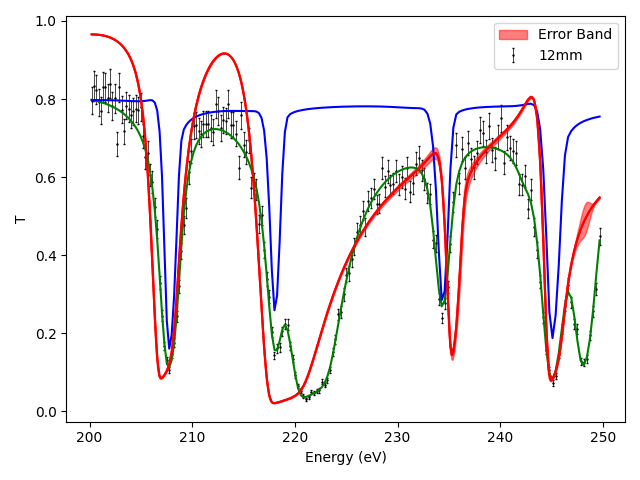

In [ ]:

### Plot 
figure()

errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

plot(data.E, data.true, 'g')

plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_trans, 'b')
plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_trans_bayes, 'r')

# plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_xs, 'b')
# plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_xs_bayes, 'r')
# # plot(sammyOUT_old.est_df.E, sammyOUT_old.est_df.theo, 'b')
# # sammyOUT_old = copy(sammyOUT2)

x = sammyOUT2.est_df.E
y = sammyOUT2.est_df.theo
y_err=  sammyOUT2.est_df.theo_unc #
# y_err = np.sqrt(np.diag(sammyOUT2.ECSCM))
fill_between(x, y - y_err, y + y_err, color='r', alpha=0.5, label='Error Band')
plot(x, y, 'r')

ylabel("T")

# xlim([200,225])
# ylim([-0.1,1.1])
legend()

xlabel('Energy (eV)')
tight_layout()


# figure()
# imshow(sammyOUT2.ECSCM)
# colorbar()

In [ ]:
ladder = copy(sammyOUT2.par_post)
print(ladder)
Ta_pair.spin_groups

            E          Gg         Gn1  varyE  varyGg  varyGn1  J_ID
0  210.215481    0.000009    0.000010    1.0     1.0      1.0   1.0
1  227.827455  340.521908   14.015338    1.0     1.0      1.0   1.0
2  238.459954 -522.547919  571.377856    1.0     1.0      1.0   1.0
3  243.898358    0.000009    0.000010    1.0     1.0      1.0   1.0
4  246.069748  701.937209    0.000010    1.0     1.0      1.0   1.0


{3.0: {'Jpi': 3.0,
  'J_ID': 1,
  '<D>': 8.79,
  '<gn2>': 465,
  'n_dof': 1,
  '<gg2>': 350,
  'g_dof': 1000,
  'quantiles': {'D01': 0.9943384234177864,
   'D99': 21.284662911191237,
   'gn01': 0.07304585392801136,
   'gn99': 3085.2269194748646,
   'gg01': 314.61935642536463,
   'gg99': 387.43914802327606,
   'gt01': 314.69240227929265,
   'gt99': 3472.666067498141},
  'chs': 1,
  'Ls': [0]}}

: 

In [ ]:
from ATARI.utils.atario import expand_sammy_ladder_2_atari

expand_sammy_ladder_2_atari(Ta_pair, ladder)
ladder

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID,gg2,gn2,Jpi,L
0,210.215481,0.000009,0.000010,1.0,1.0,1.0,1.0,0.000005,0.000195,3.0,0.0
1,227.827455,340.521908,14.015338,1.0,1.0,1.0,1.0,170.260954,261.494416,3.0,0.0
2,238.459954,-522.547919,571.377856,1.0,1.0,1.0,1.0,-261.273959,10420.236167,3.0,0.0
3,243.898358,0.000009,0.000010,1.0,1.0,1.0,1.0,0.000005,0.000180,3.0,0.0
4,246.069748,701.937209,0.000010,1.0,1.0,1.0,1.0,350.968605,0.000185,3.0,0.0


In [ ]:
# samples = 100

# cov_true = np.zeros([len(sammyOUT2.pw),len(sammyOUT2.pw)])
# cov_est = np.zeros([len(sammyOUT2.est_df),len(sammyOUT2.est_df)])

# for i in range(samples):
#     # synT.run(sammyOUT.pw)
#     data.exp = np.random.default_rng().normal(synT.data.true, std)
#     data.exp_unc = std
#     sammyINP.experimental_data = synT.data
#     sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#     residual = np.atleast_2d(sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#     cov_true += residual.T@residual
#     cov_est += sammyOUT2.ECSCM
#     # true.append(cov_true)
#     # est.append(cov_est)

In [ ]:
# iest = 0
# fig, axes = subplots(1,2, figsize=(10,4))
# # im1 = axes[0].imshow(np.log10(cov_true/(samples)))
# # im2 = axes[1].imshow(np.log10(cov_est/(samples-1)))
# im1 = axes[0].pcolormesh(cov_true/(samples), clim=(-1e-5, 8e-5))
# im2 = axes[1].pcolormesh(cov_est/(samples-1), clim=(-1e-5, 8e-5))
# axes[0].set_title("empirical")

# axes[1].set_title("estimated")
# # for ax in axes:
# colorbar(im1)

# colorbar(im2)

# print("Empirical Fnorm")
# print(np.linalg.norm(cov_true/(samples), ord='fro'))
# print("Estimated Fnorm")
# print(np.linalg.norm(cov_est/(samples-1), ord='fro'))

In [ ]:
# ### Plot 
# figure()

# # errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
# #                                         fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

# # plot(synT.data.E, synT.data.true, 'g')
# plot(synT.data.E, np.sqrt(np.diag(cov_true/samples)), label="empirical")
# plot(x, np.sqrt(np.diag(cov_est/(samples-1))), label="mean estimated")


# xlim([200,225])
# # ylim([-0.1,1.1])
# legend()

# xlabel('Energy (eV)')
# tight_layout()

In [ ]:
# # result_dict = {}
# # stds = [0.1, 0.01, 0.001, 0.0001]
# stds = [0.00001, 0.05]

# for istd in stds:
#     samples = 1000
#     cov_true = np.zeros([len(sammyOUT2.pw), len(sammyOUT2.pw)])
#     cov_est = np.zeros([len(sammyOUT2.est_df), len(sammyOUT2.est_df)])
#     for i in range(samples):
#         # synT.run(sammyOUT.pw)
#         synT.data.exp = np.random.default_rng().normal(synT.data.true, istd)
#         synT.data.exp_unc = istd
#         sammyINP.experimental_data = synT.data
#         sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#         residual = np.atleast_2d(
#             sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#         cov_true += residual.T@residual
#         cov_est += sammyOUT2.ECSCM
        
#     result_dict[istd] = [cov_true, cov_est]

In [ ]:
# stds = [1.0, 0.1, 0.05, 0.01, 0.001, 0.0001]
# true= []
# est = []

# for istd in stds:
#     res = result_dict[istd]
#     cov_true = res[0]
#     cov_est = res[1]
#     print(istd)
#     # print("Empirical Fnorm: ", np.linalg.norm(cov_true/(samples), ord='fro'))
#     # print("Estimated Fnorm: ", np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     # true.append(np.linalg.norm(cov_true/(samples), ord='fro'))
#     # est.append(np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     print("Empirical Fnorm: ", np.sum(np.diag(cov_true)**2/(samples)))
#     print("Estimated Fnorm: ", np.sum(np.diag(cov_est)**2/(samples-1)))
#     true.append(np.sum(np.diag(cov_true)**2/(samples)))
#     est.append(np.sum(np.diag(cov_est)**2/(samples-1)))

In [ ]:
# figure()
# plot(stds, true, '.', label='Empirical')
# plot(stds, est, '.r', label='Estimate')
# xscale("log")
# yscale("log")
# legend()
# # ylabel("Noise Level")
# xlabel("Noise Level")